In [ ]:
!apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
!apt install python3-pandas

### big matrices

In [8]:
#run_times = ['09-02-2025_01_19_00', '09-02-2025_03_05_57'] # spectral orthonormal
#run_times = ['10-02-2025_00_20_55', '10-02-2025_02_16_16'] # spectral graph 
#run_times = ['17-06-2025_01_29_37', '17-06-2025_07_37_28'] # frobenius gaussian
#run_times = ['17-06-2025_12_57_22', '17-06-2025_19_07_09'] # frobenius orthonormal
#run_times = ['18-06-2025_00_31_20', '18-06-2025_06_38_36'] # frobenius graph

# Newest
run_times = ['22-07-2025_01_36_09', '22-07-2025_09_57_56'] # spectral orthonormal
#run_times = ['22-07-2025_13_08_44', '22-07-2025_21_17_09'] # spectral graph 


### small matrices (for diploma)

In [14]:
#run_times = ['20-06-2025_17_20_12', '20-06-2025_17_25_11'] # frobenius gaussian
# run_times = ['20-06-2025_17_26_27', '20-06-2025_17_31_34'] # spectral gaussian

#run_times = ['20-06-2025_17_32_54', '20-06-2025_17_37_57'] # frobenius graph
#run_times = ['21-06-2025_14_52_45', '21-06-2025_14_57_47'] # spectral graph

# without dynamic step delta
#run_times = ['21-06-2025_17_22_48', '21-06-2025_17_27_27'] # spectral graph

# without dynamic step delta 2
# run_times = ['21-06-2025_18_58_06', '21-06-2025_19_05_55'] # spectral graph

# 64 mpp
#run_times = ['24-06-2025_21_14_42', '24-06-2025_21_31_03'] # frobenius gaussian
#run_times = ['24-06-2025_21_34_54', '24-06-2025_21_50_54'] # spectral gaussian

#run_times = ['24-06-2025_21_54_43', '24-06-2025_22_10_43'] # frobenius graph
#run_times = ['24-06-2025_22_14_29', '24-06-2025_22_30_31'] # spectral graph

# spectral selection strategies comparison
#run_times = ['30-06-2025_22_27_37', '30-06-2025_22_50_15'] # frobenius gaussian
#run_times = ['30-06-2025_22_54_34', '30-06-2025_23_17_40'] # spectral gaussian

#run_times = ['30-06-2025_23_21_51', '30-06-2025_23_44_39'] # frobenius graph
#run_times = ['30-06-2025_23_48_50', '01-07-2025_00_11_28'] # spectral graph

# spectral selection strategies comparison 2

#run_times = ['13-07-2025_14_41_22', '13-07-2025_15_01_45'] # spectral gaussian
#run_times = ['13-07-2025_15_05_11', '13-07-2025_15_25_46'] # spectral graph

# for poster

#run_times = ['27-07-2025_01_33_32', '27-07-2025_01_36_14'] # spectral orthonormal
#run_times = ['27-07-2025_01_41_20', '27-07-2025_01_44_06'] # frobenius orthonormal

#run_times = ['27-07-2025_01_49_15', '27-07-2025_01_51_57'] # spectral graph
run_times = ['27-07-2025_01_56_47', '27-07-2025_01_59_28'] # frobenius graph



## Drawing confidence band

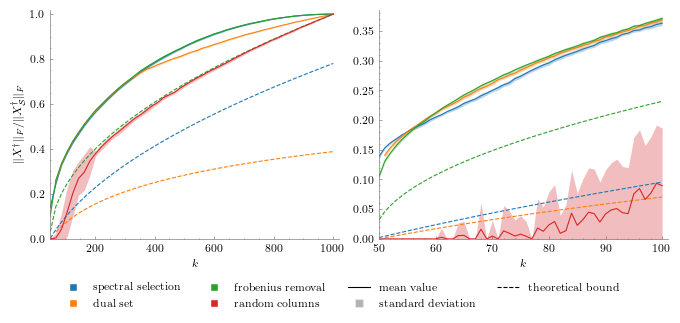

In [15]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# LaTeX configuration and style setup
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 8,
    "axes.titlesize": 8,
    "legend.fontsize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "lines.linewidth": 0.8,
    "axes.linewidth": 0.5,
    "axes.edgecolor": 'gray'
})

# Document dimensions
cm = 1/2.54  # centimeters in inches
text_width = 17 * cm

# Plot parameters
FIG_SIZE = (text_width, 0.5 * text_width * 0.8)  # Golden ratio
SHOW_LEGEND = True  #Set this to True when needed

def create_subplot(position, run_time, ax):
    path = '../out/run_' + run_time + '/'
    with open(path + 'run_info.json', 'r') as file:
        run_info = json.load(file)

    max_y = 0
    for idx, algorithm in enumerate(run_info['algorithms']):
        algorithm_underscored = algorithm.replace(' ', '_')

        points = pd.read_csv(path + algorithm_underscored + '_points.csv')
        bound = pd.read_csv(path + algorithm_underscored + '_bound.csv')

        k_values = np.sort(points['k'].unique())
        sqrt_values = np.sqrt(points['value'])

        mean_values = sqrt_values.groupby(points['k']).mean()
        std_values = sqrt_values.groupby(points['k']).std()
        ci = std_values

        color = plt.cm.tab10(idx)

        #ax.scatter(points['k'], np.sqrt(points['value']), color=color, alpha=0.1, s=1)

        ####

        # Main plot with confidence interval
        ax.set_xlim(k_values[0], k_values[0] + (k_values[-1] - k_values[0]) * (51.0 / 50))
        max_y = max(max_y, np.max(sqrt_values))
        ax.set_ylim(0, max_y * (51.0 / 50))
        ax.plot(k_values, mean_values, color=color)
        ax.fill_between(k_values, mean_values - ci, mean_values + ci,
                        color=color, alpha=0.3, linewidth=0)


        # Theoretical bound
        if not (bound['value'] == 0).all():
            ax.plot(bound['k'], np.sqrt(bound['value']),
                    color=color, linestyle='--')
    # Manage tiks
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', length=2, width=0.5, color='gray', direction='in')
    ax.tick_params(axis='both', which='minor', length=1, width=0.5, color='gray', direction='in')


    # Axis labels
    ax.set_xlabel(r'$k$')
    if position == 'left':
        ax.set_ylabel(r'$\Vert X^\dag \Vert_F / \Vert X_\mathcal{S}^\dag \Vert_F$')

    # Grid and borders
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def create_plot(run_times):
    fig, ax = plt.subplots(figsize=FIG_SIZE, nrows=1, ncols=2, layout='constrained')

    create_subplot('left', run_times[0], ax[0])
    create_subplot('right', run_times[1], ax[1])

    path = '../out/run_' + run_times[0] + '/'
    with open(path + 'run_info.json', 'r') as file:
        run_info = json.load(file)

    # Create custom legend
    if SHOW_LEGEND:
        custom_legend = []
        for algorithm in run_info['algorithms']:
            color = plt.cm.tab10(list(run_info['algorithms']).index(algorithm))
            custom_legend.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markeredgecolor='white', label=algorithm, markersize=6))

        custom_legend.append(plt.Line2D([0], [0], linestyle='-', label='mean value', color='black'))
        custom_legend.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markeredgecolor='white', alpha=0.3, label='standard deviation', markersize=6))
        custom_legend.append(plt.Line2D([0], [0], linestyle='--', label='theoretical bound', color='black'))

        leg = fig.legend(handles=custom_legend, framealpha=0.9,
                       loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, ncols=4)
        #leg.get_frame().set_linewidth(0.5)
        leg.get_frame().set_edgecolor("1")

    plt.savefig('plot.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

create_plot(run_times)

## Russian version

In [53]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 16

# Open and read the JSON file
path = '../out/run_' + run_time + '/'
with open(path + 'run_info.json', 'r') as file:
    run_info = json.load(file)

# Create a single figure
plt.figure(figsize=(10, 6))
alg_names = ["новый алгоритм",
             "алгоритм 2 из [1]",
      "алгоритм 3 из [1]",
      "случайные столбцы"]

# Iterate over algorithms and plot confidence intervals
i = 0
for algorithm in run_info['algorithms']:
    algorithm_undersored = algorithm.replace(' ', '_')

    points = pd.read_csv(path + algorithm_undersored + '_points.csv')
    bound = pd.read_csv(path + algorithm_undersored + '_bound.csv')

    # Calculate mean and standard deviation of points for each k
    k_values = points['k'].unique()
    k_values = np.sort(k_values)
    mean_values = np.array([np.sqrt(points[points['k'] == k]['value']).mean() for k in k_values])
    std_values = np.array([np.sqrt(points[points['k'] == k]['value']).std() for k in k_values])
    upper_values = mean_values + 1.96 * std_values
    lower_values = mean_values - 1.96 * std_values

    # Plot confidence interval
    plt.plot(k_values, mean_values)
    plt.plot(k_values, upper_values, color=plt.cm.tab10(list(run_info['algorithms']).index(algorithm)), alpha = 0.0)
    plt.plot(k_values, lower_values, color=plt.cm.tab10(list(run_info['algorithms']).index(algorithm)), alpha = 0.0)
    plt.fill_between(k_values, lower_values, upper_values, alpha=0.33, color=plt.cm.tab10(list(run_info['algorithms']).index(algorithm)))

    # Check if bound is all zeros
    if not (bound['value'] == 0).all():
        plt.plot(bound['k'], np.sqrt(bound['value']), linestyle='--', color=plt.cm.tab10(list(run_info['algorithms']).index(algorithm)))
    i += 1

# Set title and labels
plt.xlabel('k')
plt.ylabel(r'$\Vert X^\dag \Vert_2 / \Vert X_S^\dag \Vert_2$')
# Create custom legend
custom_legend = []
i = 0
for algorithm in run_info['algorithms']:
    color = plt.cm.tab10(list(run_info['algorithms']).index(algorithm))
    custom_legend.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=alg_names[i], markersize=10))
    i+=1
plt.legend(handles=custom_legend, loc='best')

# Save plot
plt.tight_layout()
plt.savefig(path + 'confidence_intervals_plot_ru.svg')
plt.close()